# 函数、库准备

In [1]:
import pykoop
from sklearn.preprocessing import MaxAbsScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint, solve_ivp
import seaborn as sns
import math
import sklearn

In [2]:
def deriv(t, y):
    pos = y[:2*N].reshape(N,2)
    vel = y[2*N:].reshape(N,2)
    acc = np.zeros_like(pos)
    # 弹簧力
    for i,j,k_ij in springs:
        diff = pos[i] - pos[j]
        d = np.linalg.norm(diff)
        if d == 0:
            continue
        force = -k_ij*(d - L[(i,j)]) * (diff/d)
        acc[i] += force/m
        acc[j] -= force/m  # 反作用
    dydt = np.concatenate([vel.flatten(), acc.flatten()])
    return dydt

In [3]:
def matrix_l0_norm_corrected(matrix, threshold=1e-10):
    """
    计算矩阵的L0范数（各列非零元素数量的最大值）
    
    参数:
    matrix: numpy数组或可以转换为numpy数组的矩阵
    threshold: 阈值，绝对值小于此值的元素视为零
    
    返回:
    l0_norm: 矩阵的L0范数（整数）
    column_norms: 各列的L0范数
    """
    matrix = np.array(matrix, dtype=float)
    
    # 应用阈值：将接近零的元素视为零
    matrix_thresholded = np.where(np.abs(matrix) < threshold, 0, matrix)
    
    # 计算每列的非零元素数量
    column_norms = []
    for col in range(matrix_thresholded.shape[1]):
        non_zero_count = np.count_nonzero(matrix_thresholded[:, col])
        column_norms.append(non_zero_count)
    
    # 矩阵的L0范数是各列L0范数的最大值
    l0_norm = max(column_norms)
    
    return l0_norm

In [4]:
def matrix_l1_norm_manual(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    # 计算每列的绝对值之和
    column_sums = []
    for j in range(cols):
        col_sum = 0
        for i in range(rows):
            col_sum += abs(matrix[i][j])
        column_sums.append(col_sum)
    
    # 返回最大的列和
    return max(column_sums)

In [5]:
def matrix_l2_norm_manual(matrix):
    rows = len(matrix)
    cols = len(matrix[0])
    
    # 计算每列的平方之和
    column_sums = []
    for j in range(cols):
        col_sum = 0
        for i in range(rows):
            col_sum += matrix[i][j] ** 2 
        column_sums.append(math.sqrt(col_sum))
    
    # 返回最大的列和
    return max(column_sums)

# 实验

In [11]:
# 参数定义
N = 4  # 振子数量
m = 1.0  # 质量
k_strong = 50.0
k_weak = 1

# 振子分组
groups = {0:'a',1:'a',2:'b',3:'b'}
springs = []  # (i, j, k_ij)

for i in range(N):
    for j in range(N):
        if i <= j :
            if groups[i] == groups[j]:
                springs.append((i, j, k_strong))
            else:
                springs.append((i, j, k_weak))

# 初始位置
pos_init = np.array([
    [-1.0, -0.5], [-1.0, 0.5],    # group 1
    [1.0, 0.5],  [1.0, -0.5]      # group 2
])
pos_init += np.random.randn(N,2)*0.1  # 加一点扰动

# 计算自然长度
L = {}
for i,j,k in springs:
    if groups[i] == groups[j]:
        L[(i,j)] = 0.5 
    else:
        L[(i,j)] = 3

# 初始速度
vel_init = np.zeros((N,2))

# 状态展开
y0 = np.concatenate([pos_init.flatten(), vel_init.flatten()])

# 积分
t_span = [0, 100]
t_eval = np.linspace(0, 100, 10000)
sol = solve_ivp(deriv, t_span, y0, t_eval=t_eval)
#sol = solve_ivp(deriv, t_span, y0, t_eval=t_eval, method='RK45')

# 提取轨迹数据
traj = sol.y[:2*N,:].reshape(N,2,-1)
vels = sol.y[2*N:,:].reshape(N,2,-1)

# 将所有振子的位置和速度展平为单一数据矩阵
# 数据格式: [x1, y1, x2, y2, x3, y3, x4, y4, x5, y5, x6, y6, vx1, vy1, ..., vx6, vy6]
positions = traj.reshape(N*2, -1).T  # 形状: (10000, 12)
velocities = vels.reshape(N*2, -1).T  # 形状: (10000, 12)

# 合并位置和速度数据
data_noiseless = np.hstack([positions, velocities])  # 形状: (10000, 24)

# 添加微小噪声（与SIR实验相同）
noise_mean = 0.0
noise_std = 0.001
noise = noise_mean + np.random.randn(*data_noiseless.shape) * noise_std
data_noisy = data_noiseless + noise

data = data_noisy[:-1000]
t = t_eval[:-1000]

In [12]:
data.shape

(9000, 16)

In [25]:
data

array([[-9.89971226e-01, -5.69505346e-01, -9.26161626e-01, ...,
        -5.50666160e-04,  1.46482311e-03, -2.03892721e-03],
       [-9.89140820e-01, -5.66235331e-01, -9.27412288e-01, ...,
        -2.05397472e-01, -4.50406911e-02,  2.07815215e-01],
       [-9.90746850e-01, -5.61716435e-01, -9.28919410e-01, ...,
        -4.10024443e-01, -9.15784186e-02,  4.17369940e-01],
       ...,
       [-8.24020938e-01, -1.55227697e+00, -1.19453478e+00, ...,
         3.38599928e-01, -1.91899451e-01,  1.85611497e-01],
       [-8.37996169e-01, -1.57683773e+00, -1.18400436e+00, ...,
         2.02925946e-01,  4.30764233e-03,  2.81715211e-01],
       [-8.51638189e-01, -1.59881855e+00, -1.17308771e+00, ...,
         7.20759613e-02,  2.07769763e-01,  3.76350941e-01]])

In [14]:
print('任意维度是否 inf  :', np.any(np.isinf(data)))
print('任意维度是否 NaN :', np.any(np.isnan(data)))
print('最大值  :', np.nanmax(data))
print('最小值  :', np.nanmin(data))

任意维度是否 inf  : False
任意维度是否 NaN : False
最大值  : 3.668386365876703
最小值  : -3.650296943094339


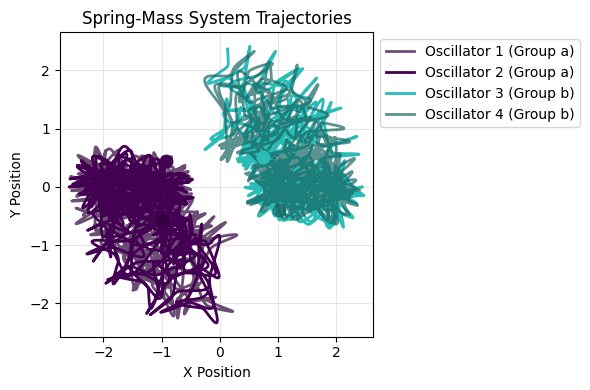

In [15]:
# 1. 轨迹图和速度模长图
unique_groups = sorted(list(set(groups.values()))) 
color_map = {group: plt.cm.viridis(i/len(unique_groups)) for i, group in enumerate(unique_groups)}
oscillator_colors = plt.cm.tab10(np.arange(6))  # 每个振子不同颜色
fig, ax = plt.subplots(figsize=(6, 4))

# 绘制每个振子的轨迹
for i in range(N):
    group = groups[i]
    base_color = color_map[group]  # 基于组的基础颜色
    
    # 调整亮度生成振子专属颜色（保持在0-1范围内）
    oscillator_color = np.array(base_color) * (0.7 + 0.3 * (i % 3))
    oscillator_color = np.clip(oscillator_color, 0, 1)
    
    # 使用ax对象绘图（统一使用子图对象，避免plt和ax混用）
    ax.plot(traj[i, 0, :], traj[i, 1, :], 
            color=oscillator_color, linewidth=2,
            label=f'Oscillator {i+1} (Group {group})')
    
    # 绘制轨迹起点（用更大的点标记）
    ax.scatter(traj[i, 0, 0], traj[i, 1, 0], 
               color=oscillator_color, s=80, zorder=10, marker='o')

# 设置图形属性
ax.set_xlabel('X Position')
ax.set_ylabel('Y Position')
ax.set_title('Spring-Mass System Trajectories')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))  # 图例放在图外避免遮挡
ax.grid(True, alpha=0.3)
ax.axis('equal')  # 等比例显示，避免轨迹变形

plt.tight_layout()
plt.show()

# koopman

In [16]:
# 多项式（DMD）
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)

# 训练Koopman模型（弹簧振子数据没有外部输入）
kp.fit(data, n_inputs=0)
error = -kp.score(data)
error

1.1906653122022104

In [26]:
# 多项式（EDMD）    
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('pl', pykoop.PolynomialLiftingFn(order=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=100),
)

# 训练Koopman模型（弹簧振子数据没有外部输入）
kp.fit(data, n_inputs=0)
error = -kp.score(data)
error

1.187530310042959

In [28]:
# 径向基函数
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('rbf', pykoop.RbfLiftingFn(rbf='gaussian',centers=pykoop.ClusterCenters(estimator=sklearn.cluster.KMeans(n_clusters=24)),shape=1)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.5),
)
kp.fit(data,n_inputs=0)
error = -kp.score(data)
error

1.9414267189104863

In [72]:
#kernal，随机傅立叶表征
kp = pykoop.KoopmanPipeline(
    lifting_functions=[(
        'rff',
        pykoop.KernelApproxLiftingFn(
            kernel_approx=pykoop.RandomFourierKernelApprox(
                n_components=24,
                random_state=10,
            )),
    )],
    regressor=pykoop.Edmd(alpha=0.1),
)

kp.fit(data,n_inputs=0)
error = -kp.score(data)
error

1.8544214129760408

In [99]:
#延迟嵌入，Hankel
kp = pykoop.KoopmanPipeline(
    lifting_functions=[
        ('ma', pykoop.SkLearnLiftingFn(MaxAbsScaler())),
        ('delay', pykoop.DelayLiftingFn(n_delays_state=2)),
        ('ss', pykoop.SkLearnLiftingFn(StandardScaler()))
    ],
    regressor=pykoop.Edmd(alpha=0.9),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='unknown_noise')),
    #regressor=pykoop.Dmd(tsvd=pykoop.Tsvd(truncation='rank',truncation_param=4)),
)
kp.fit(data,n_inputs=0)
error = -kp.score(data)
error

1.1734793726024886

# 分析

In [100]:
# 模型预测和评估
p_steps = 2000  # 预测步数
X_test = data_noisy[-p_steps:, :]  # 使用前1000个点作为测试数据

pred = kp.predict_trajectory(X_test, None)
mse = np.mean((pred - X_test)**2)  
print('MSE:', mse)

MSE: 1.518092582809823


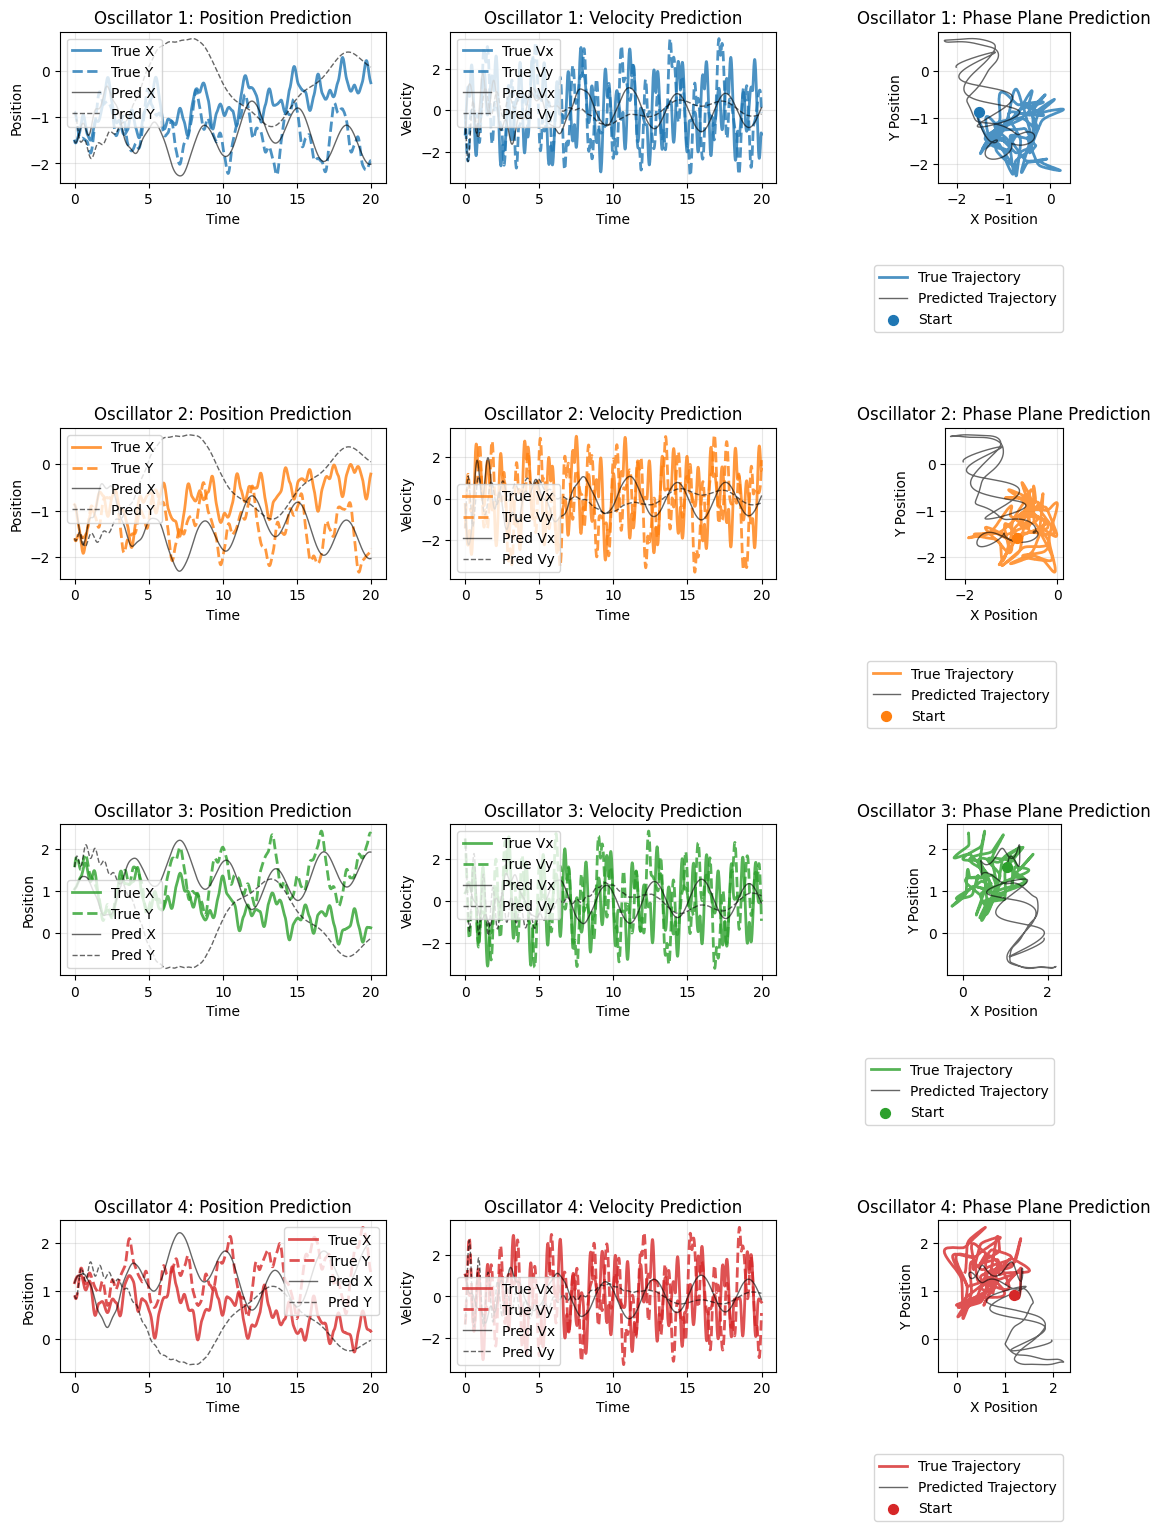

In [101]:
# 3. 预测结果可视化 - 每行三个图，每个振子一列
n_oscillators = N  # 振子数量
fig, axes = plt.subplots(n_oscillators, 3, figsize=(12, 4*n_oscillators))

# 如果只有一个振子，调整axes形状
if n_oscillators == 1:
    axes = axes.reshape(1, -1)

for i in range(n_oscillators):
    # 计算数据中的列索引
    pos_x_idx = i * 2          # 位置X列索引
    pos_y_idx = i * 2 + 1      # 位置Y列索引  
    vel_x_idx = N*2 + i * 2     # 速度X列索引（后12列是速度）
    vel_y_idx = N*2 + i * 2 + 1 # 速度Y列索引
    
    color = oscillator_colors[i]
    
    # 第一个图：X和Y位置预测
    ax1 = axes[i, 0]
    # 真实值
    ax1.plot(t[:p_steps], X_test[:, pos_x_idx], color=color, linewidth=2, 
             label=f'True X', alpha=0.8)
    ax1.plot(t[:p_steps], X_test[:, pos_y_idx], color=color, linewidth=2, 
             linestyle='--', label=f'True Y', alpha=0.8)
    # 预测值
    ax1.plot(t[:p_steps], pred[:, pos_x_idx], 'k-', linewidth=1, 
             label='Pred X', alpha=0.6)
    ax1.plot(t[:p_steps], pred[:, pos_y_idx], 'k--', linewidth=1, 
             label='Pred Y', alpha=0.6)
    
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Position')
    ax1.set_title(f'Oscillator {i+1}: Position Prediction')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # 第二个图：X和Y速度预测
    ax2 = axes[i, 1]
    # 真实值
    ax2.plot(t[:p_steps], X_test[:, vel_x_idx], color=color, linewidth=2, 
             label=f'True Vx', alpha=0.8)
    ax2.plot(t[:p_steps], X_test[:, vel_y_idx], color=color, linewidth=2, 
             linestyle='--', label=f'True Vy', alpha=0.8)
    # 预测值
    ax2.plot(t[:p_steps], pred[:, vel_x_idx], 'k-', linewidth=1, 
             label='Pred Vx', alpha=0.6)
    ax2.plot(t[:p_steps], pred[:, vel_y_idx], 'k--', linewidth=1, 
             label='Pred Vy', alpha=0.6)
    
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Velocity')
    ax2.set_title(f'Oscillator {i+1}: Velocity Prediction')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # 第三个图：相平面预测
    ax3 = axes[i, 2]
    # 真实轨迹
    ax3.plot(X_test[:, pos_x_idx], X_test[:, pos_y_idx], color=color, 
             linewidth=2, label='True Trajectory', alpha=0.8)
    # 预测轨迹
    ax3.plot(pred[:, pos_x_idx], pred[:, pos_y_idx], 'k-', linewidth=1, 
             label='Predicted Trajectory', alpha=0.6)
    # 起点标记
    ax3.scatter(X_test[0, pos_x_idx], X_test[0, pos_y_idx], color=color, 
                s=50, marker='o', zorder=10, label='Start')
    
    ax3.set_xlabel('X Position')
    ax3.set_ylabel('Y Position')
    ax3.set_title(f'Oscillator {i+1}: Phase Plane Prediction')
    ax3.legend(bbox_to_anchor=(1, -0.5))
    ax3.grid(True, alpha=0.3)
    ax3.set_aspect('equal')

plt.tight_layout()
plt.show()

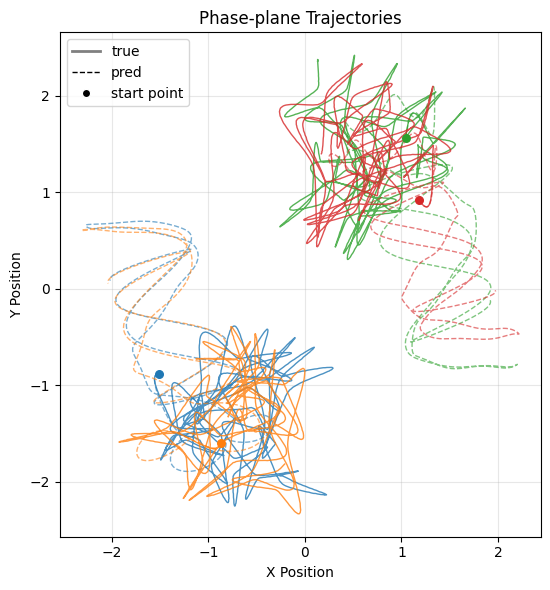

In [102]:
plt.figure(figsize=(6, 6))

for i in range(n_oscillators):
    color = oscillator_colors[i]
    pos_x_idx = 2 * i
    pos_y_idx = 2 * i + 1

    # 真实轨迹
    plt.plot(X_test[:, pos_x_idx], X_test[:, pos_y_idx],
             color=color, lw=1, label=f'Osc{i+1} True' if i < 1 else "",
             alpha=0.8)
    # 预测轨迹
    plt.plot(pred[:, pos_x_idx], pred[:, pos_y_idx], linestyle='--', 
            color=color, lw=1, label=f'Osc{i+1} Pred' if i < 1 else "",
             alpha=0.6)
    # 起点
    plt.scatter(X_test[0, pos_x_idx], X_test[0, pos_y_idx],
                color=color, s=30, zorder=10,
                label='Start' if i < 1 else "")
legend_elements = [
    plt.Line2D([0], [0], color='gray', lw=2, label='true'),
    plt.Line2D([0], [0], color='k', lw=1, ls='--', label='pred'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='k',
               markersize=6, label='start point', linestyle='')
]
plt.legend(handles=legend_elements)
plt.xlabel('X Position')
plt.ylabel('Y Position')
plt.title('Phase-plane Trajectories')
plt.grid(True, alpha=0.3)
plt.gca().set_aspect('equal')
plt.tight_layout()
plt.show()

In [103]:
A = kp.regressor_.coef_.T

In [104]:
l0 = matrix_l0_norm_corrected(A,0.05)
l1 = matrix_l1_norm_manual(A)
l2 = matrix_l2_norm_manual(A)
print(f"L0 = {l0}, L1 = {l1}, L2 = {l2}")
print(f"L0 = {l0:.2f}, L1 = {l1:.2f}, L2 = {l2:.2f}")  

L0 = 13, L1 = 4.023415700736211, L2 = 1.5140613341008657
L0 = 13.00, L1 = 4.02, L2 = 1.51


In [105]:
U,S,V = np.linalg.svd(A)
U_abs = np.abs(U)

In [106]:
print('error:', error)
print('MSE:', mse)
print(f"L0 = {l0}, L1 = {l1}, L2 = {l2}")
print(f"L0 = {l0:.2f}, L1 = {l1:.2f}, L2 = {l2:.2f}")  

error: 1.1734793726024886
MSE: 1.518092582809823
L0 = 13, L1 = 4.023415700736211, L2 = 1.5140613341008657
L0 = 13.00, L1 = 4.02, L2 = 1.51


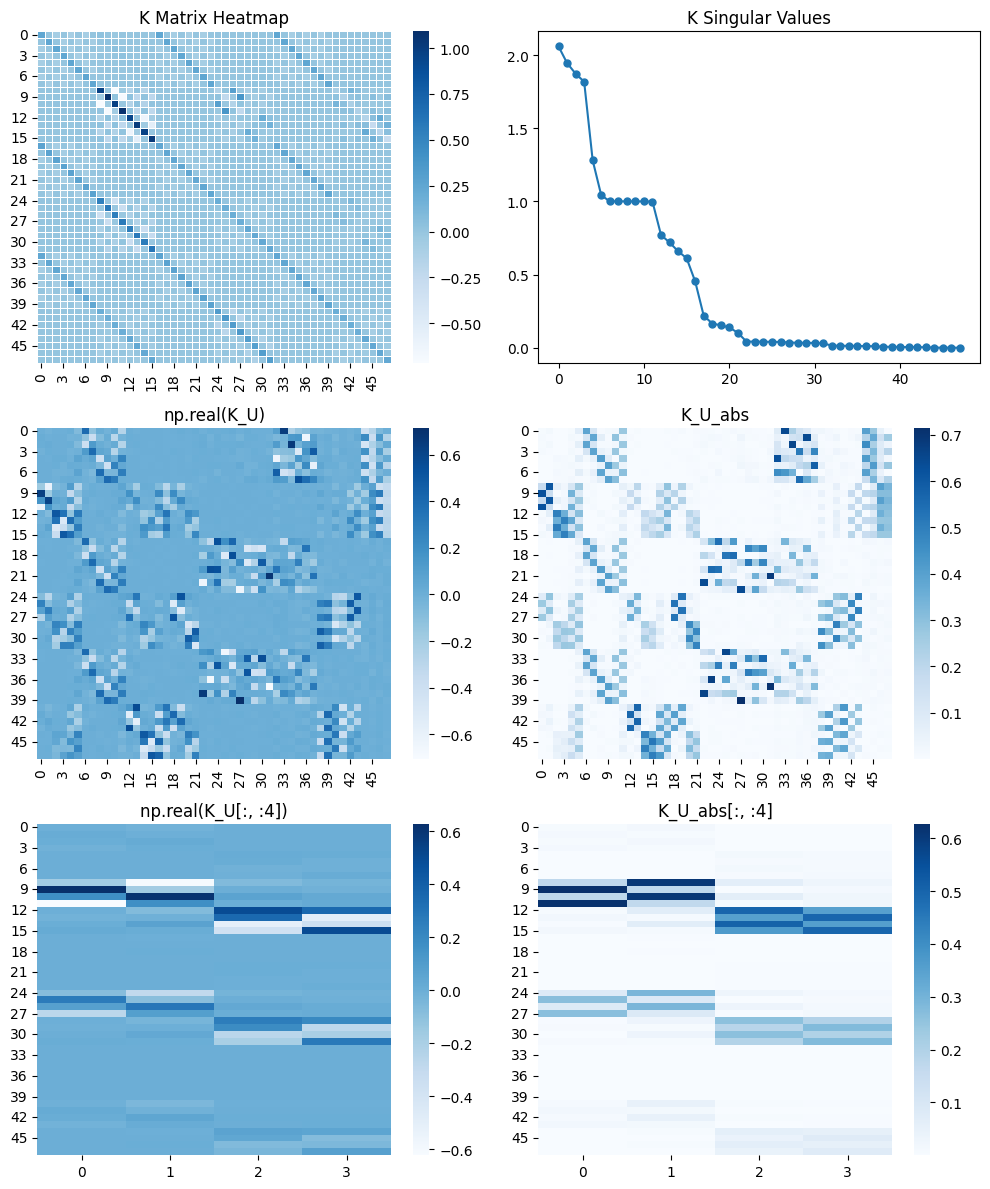

In [107]:
fig, axes = plt.subplots(3, 2, figsize=(10, 12))
axes = axes.flatten()         

sns.heatmap(A, ax=axes[0], cmap='Blues', linewidths=0.5)
axes[0].set_title('K Matrix Heatmap')

axes[1].plot(S, marker='o', markersize=5)
axes[1].set_title('K Singular Values')

sns.heatmap(np.real(U), ax=axes[2], cmap='Blues')
axes[2].set_title('np.real(K_U)')

sns.heatmap(np.abs(U), ax=axes[3], cmap='Blues')
axes[3].set_title('K_U_abs')

sns.heatmap(np.real(U[:, :4]), ax=axes[4], cmap='Blues')
axes[4].set_title('np.real(K_U[:, :4])')

sns.heatmap(np.abs(U[:, :4]), ax=axes[5], cmap='Blues')
axes[5].set_title('K_U_abs[:, :4]')

plt.tight_layout()
plt.show()